<img src="https://raw.githubusercontent.com/sebastianVP/sebastianVP/main/toulouselautrec_logo.jpg" alt= "LOGO CAT" width=400 height=400 align = "right">

<br>
<h1><font color="#7F000E" size=5>TOULOUSE LAUTREC </font></h1>
<h1><font color="#7F000R" size=6> METODOLOGÍAS EN LA CIENCIA DE DATOS </font></h1>
<h1><font color="#7F000E" size=4>  C5.5 - Del Modelo a la Evaluacion -  Guia Practica -Random Forest
 </font></h1>
<br>
<br>
<div style="text-align:right">
<font color="#7F000E" size=3> Ing. Alexander Valdez</font><br>
<font color="#7F000E" size=3> Curso 2128, Clases Lunes y Miercoles 20:00-22:30pm </font><br>
<font color="#7F000e" size=3> Quinta Sesión </font><br>
</div>

---

# Ejercicio Random Forest

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargamos Datos

In [4]:
# Descargar desde https://www.kaggle.com/mlg-ulb/creditcardfraud/data

df = pd.read_csv("/content/drive/MyDrive/DATASET_TOULOUSE_C3/creditcard.csv")
df.head(n=5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

## Vemos Desbalanceo

In [6]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
normal_df = df[df.Class == 0] #registros normales
fraud_df = df[df.Class == 1] #casos de fraude

## Creamos Dataset

In [8]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [10]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Ejecutamos Modelo con LogisticRegresion para poder Comparar

In [11]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


### Veamos como responde en el test set

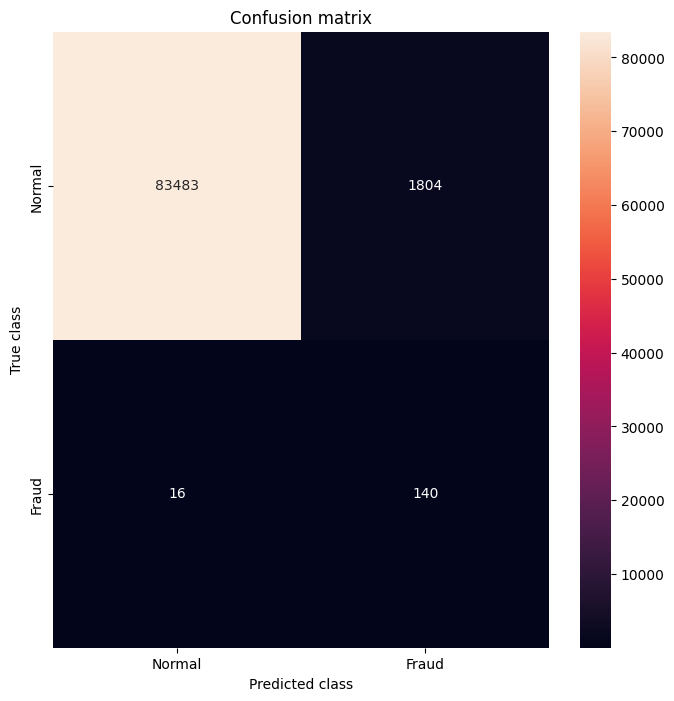

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85287
           1       0.07      0.90      0.13       156

    accuracy                           0.98     85443
   macro avg       0.54      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [12]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Probamos con Random Forest

## ATENCION: Este modelo toma algo más de tiempo en entrenar

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100,
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(verbose=2)

### Revisemos los resultados

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


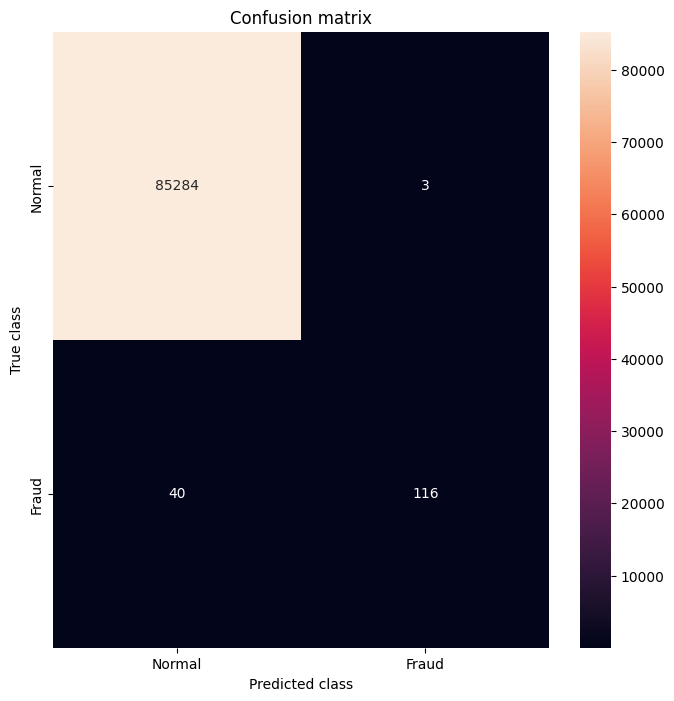

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85287
           1       0.97      0.74      0.84       156

    accuracy                           1.00     85443
   macro avg       0.99      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [14]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Otro Bosque: Random Forest -más veloz-

In [15]:
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   46.2s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(class_weight='balanced', max_depth=6, oob_score=True,
                       random_state=50, verbose=2)

## Veamos la Confusion Matrix con el conjunto de Test

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


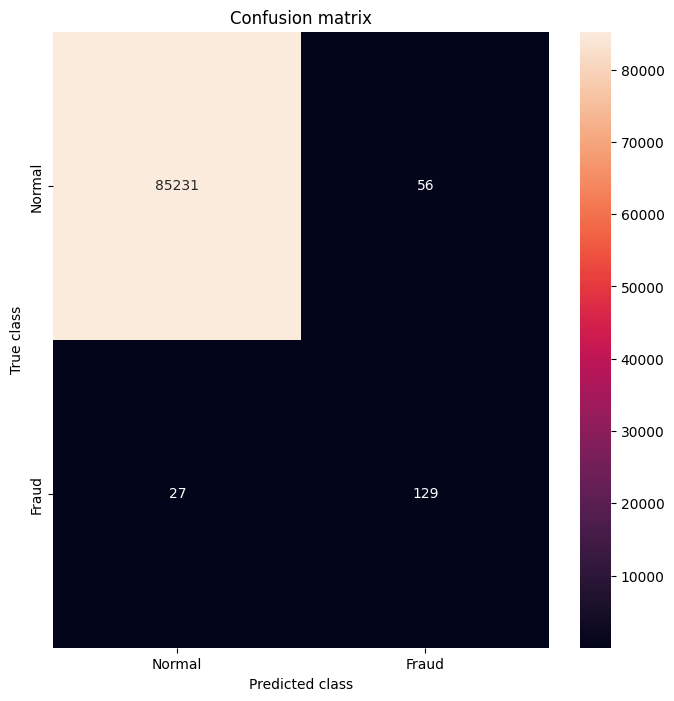

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85287
           1       0.70      0.83      0.76       156

    accuracy                           1.00     85443
   macro avg       0.85      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443



In [16]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Comprobamos Resultados

In [17]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [ ]:
print(roc_value)

0.9216517085479026


El valor de roc cuanto más cerca de 1, mejor. si fuera 0.5 daría igual que fuesen valores aleatorios y sería un mal modelo